# PhotoRing Utilities
## Computing the probability distribution of ring parameters from observed stellar density
### The case of Kepler-51 b
### By Jorge I. Zuluaga & David Kipping

In [1]:
#############################################################
# Librries
#############################################################
import photoring as pr
import photoring.constants as c
import pickle
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d
from scipy.stats import norm
from copy import deepcopy
import time
import os

#############################################################
# Configuration
#############################################################
# Check if this is a notebook or a stand alone script
try:
    get_ipython
except:
    get_ipython = pr.get_ipython

#############################################################
# Inputs
#############################################################
# Total number of processors
num_procs = int(pr.check_opts('num_procs',4))

# Total size of the sample
samples = int(pr.check_opts('samples',100))

# Name of the sample
sample_suffix = pr.check_opts('suffix','MR_simple_variance')

# Alert
alert = pr.check_opts('alert',False)

%load_ext autoreload
%autoreload 2

Photoring version 0.1.0


## Stellar properties

In [2]:
print(pr.BARL + "Loading stellar properties\n" + pr.BARL)
# Unpickle the functions
with open(pr.DATA_DIR + 'kepler51/rho_true_fun.pkl', 'rb') as f:
    rho_true_fun = pickle.load(f)

df = pd.read_csv(pr.DATA_DIR + 'GKTHCatalogue.csv')
k51 = df[df['id_starname'] == 'kic11773022']

rho_true_sun = c.MSUN/(4/3 * np.pi * c.RSUN**3)

M_mean = k51.iso_mass.values[0]
R_mean = k51.iso_rad.values[0]
M_std = (k51.iso_mass_err1.values[0] + abs(k51.iso_mass_err2.values[0]))/2
R_std = (k51.iso_rad_err1.values[0] + abs(k51.iso_rad_err2.values[0]))/2

Ms_mean = M_mean*c.MSUN
Ms_std = M_std*c.MSUN
Rs_mean = R_mean*c.RSUN
Rs_std = R_std*c.RSUN

print(f"Mass: {M_mean} +/- {M_std}")
print(f"Radius: {R_mean} +/- {R_std}")

mean = [M_mean, R_mean]
rho_MR = -0.2
cov = [
    [M_std**2, rho_MR * M_std * R_std], 
    [rho_MR * M_std * R_std, R_std**2]
]

Ng = 5
ts = 2
MS, RS = np.meshgrid(
    np.linspace(Ms_mean - ts*Ms_std, Ms_mean + ts*Ms_std, Ng)/c.MSUN,
    np.linspace(Rs_mean - ts*Rs_std, Rs_mean + ts*Rs_std, Ng)/c.RSUN
)
delta_Ms = MS[0,1] - MS[0,0]
delta_Rs = RS[1,0] - RS[0,0]

PS = np.zeros(MS.shape)
for i in range(MS.shape[0]):
    for j in range(RS.shape[1]):
        PS[i, j] = multivariate_normal.pdf([MS[i, j], RS[i, j]], mean=mean, cov=cov)
PS = PS*delta_Ms*delta_Rs

**************************************************
Loading stellar properties
**************************************************

Mass: 0.9146640833784588 +/- 0.04980093747925855
Radius: 0.8688315952605846 +/- 0.02891379267492005


## Planet properties

In [5]:
print(pr.BARL + "Loading planetary properties\n" + pr.BARL)

with open(pr.DATA_DIR + 'kepler51/rho_obs_d_fun.pkl', 'rb') as f:
    rho_obs_fun = pickle.load(f)

# https://exoplanetarchive.ipac.caltech.edu/overview/Kepler-51
# Planet b: Masuda et al. 2024
system_prefix = 'k51-planet_d'
rho_obs_fun = rho_obs_fun

# If Rp and Rstar is known:
Rp_mean = 0.831*c.RJUP # Masuda et al. 2024
Rp_std = 0.016*c.RJUP # Masuda et al. 2024

# Orbital period
Porb_mean = 130.1858*c.DAY # Masuda et al. 2024
Porb_std = 0.0018*c.DAY # Masuda et al. 2024

# Impact parameter
borb_mean = 0.0030 # Masuda et al. 2024
borb_std = 0.0950 # Masuda et al. 2024

# Planetary mass
Mp_mean = 0.021*c.MJUP
Mp_std = 0.003*c.MJUP

print(f"Radius: {Rp_mean/c.RJUP} +/- {Rp_std/c.RJUP}")
print(f"Mass: {Mp_mean/c.MJUP} +/- {Mp_std/c.MJUP}")
print(f"Period: {Porb_mean/c.DAY} +/- {Porb_std/c.DAY}")
print(f"Impact parameter: {borb_mean} +/- {borb_std}")

**************************************************
Loading planetary properties
**************************************************

Radius: 0.831 +/- 0.016
Mass: 0.021 +/- 0.003
Period: 130.1858 +/- 0.0017999999999999997
Impact parameter: 0.003 +/- 0.095


In [6]:
print(pr.BARL + "Planetary system sheet\n" + pr.BARL)

# ============================
# TRANSIT DEPTH
# ============================
delta_mean = (Rp_mean/Rs_mean)**2
delta_std = 2*delta_mean*(Rp_std/Rp_mean + Rs_std/Rs_mean)
print(f"Transit depth: {delta_mean*100:.2f} +/- {delta_std*100:.2f} %")

# ============================
# SEMIMAJOR AXIS
# ============================
# Semimajor axis
ap_mean = ((c.GCONST * Ms_mean * Porb_mean**2) / (4 * np.pi**2))**(1/3)
ap_std = 1/3*ap_mean*(Ms_std/Ms_mean + 2*Porb_std/Porb_mean)
print(f"Semimajor axis: {ap_mean/c.AU:.4f} +/- {ap_std/c.AU:.4f} au = {ap_mean/Rs_mean:.2f} Rs")

# ============================
# ORBITAL INCLINATION
# ============================
iorb_mean = np.arccos(borb_mean*Rs_mean/ap_mean)*c.RAD
iorb_std = np.sqrt((borb_std * Rs_mean / ap_mean)**2 + \
                   (borb_mean * Rs_std / ap_mean)**2 + \
                   (borb_mean * Rs_mean * ap_std / ap_mean**2)**2) * c.RAD
print(f"Orbital inclination: {iorb_mean:.2f} +/- {iorb_std:.2f} degrees")

# ============================
# MINIMUM PLANET RADIUS
# ============================
Rp_min = c.REARTH*(Mp_mean/c.MEARTH)**(1/3)
fRp_min = Rp_min/Rp_mean
print(f"Minimum planet radius: {Rp_min/c.RJUP:.4f} RJup")
print(f"Minimum planet radius in terms of the ringless planet radius: {fRp_min:.4f} Rp")

System = pr.RingedSystem(
    system = dict(
        Mstar=Ms_mean,
        Rstar=Rs_mean,
        Rplanet=Rp_mean, 
        Mplanet=Mp_mean, 
        ap=ap_mean, #Semi-major axis 
        iorb=iorb_mean*c.DEG, #Orbital inclination
        fe=1, #Exterior ring (Rp)
        fi=1, #Interior ring (Rp)
        ir=0.0*c.DEG, #Ring inclination
        phir=0.0*c.DEG, #Ring roll angle
        tau=1.0, #Opacity
    )
)
System.noauto = True

# Useful additional parameters
System.Porb_mean = Porb_mean
System.borb_mean = borb_mean
System.delta_mean = delta_mean
System.delta_std = delta_std
System.delta_fun = lambda x:norm.pdf(x, delta_mean, delta_std)
System.rho_obs_fun = rho_obs_fun
System.rho_true_fun = rho_true_fun

# Adjust
print()
print("After adjustment:")
pr.standard_adjust_params(System,True)

System.calculate_PR()
print(f"rho_obs: {System.rho_obs}, rho_true: {System.rho_true}, PR: {System.PR}")

**************************************************
Planetary system sheet
**************************************************

Transit depth: 0.92 +/- 0.10 %
Semimajor axis: 0.4880 +/- 0.0089 au = 120.66 Rs
Orbital inclination: 90.00 +/- 0.05 degrees
Minimum planet radius: 0.1716 RJup
Minimum planet radius in terms of the ringless planet radius: 0.2065 Rp

After adjustment:
Semimajor axis: 0.4880 au = 120.66 Rs
Orbital inclination: 90.00 degrees
rho_obs: 1960.7144747628813, rho_true: 1960.8074257658545, PR: -2.0587980233276908e-05


## Monte Carlo Fit

### Variable radius

In [7]:
print(pr.BARL + "Monte Carlo fitting\n" + pr.BARL)

# Parameter space
props = dict(
    fe = dict(
        label=r"$f_e$",
        range=[1.1,6.0],
        scale=1,
    ),
    Rplanet = dict(
        label=r"$R_p$ [$R_{jup}$]",
        range=[fRp_min*Rp_mean/c.RJUP, Rp_mean/c.RJUP],
        scale=c.RJUP,
    ),
    ir = dict(
        label=r"$i_r$ [deg]",
        range=[0.0, 90.0],
        scale=c.DEG,
    ),
    phir = dict(
        label=r"$\phi_r$ [deg]",
        range=[0.0, 90.0],
        scale=c.DEG,
    ),
)

# Parameters to store
store_params = dict(
    # Basic
    rho_true = dict(prop='rho_true',scale=1),
    rho_obs = dict(prop='rho_obs',scale=1),
    PR = dict(prop='PR',scale=1),
    ieff = dict(prop='ieff',scale=c.RAD),
    teff = dict(prop='teff',scale=c.RAD),
    delta = dict(prop='Ar',scale=1/np.pi),
    
    # Other
    Rstar = dict(prop='Rstar',scale=1/c.RSUN),
    Mstar = dict(prop='Mstar',scale=1/c.MSUN),
    ap = dict(prop='ap',scale=1/c.AU),
    ep = dict(prop='ep',scale=1),
    iorb = dict(prop='iorb',scale=c.RAD),
    Borb = dict(prop='Borb',scale=1),
    Porb = dict(prop='Porb',scale=1/c.DAY),
    tT = dict(prop='tT',scale=1),
    grazing = dict(prop='grazing',scale=1),
)

# Run
S = deepcopy(System)
S.tau = 1
S.fi = 1

sample_suffix = f"{sample_suffix}-N{samples:.0e}"

print(f"Running {samples} samples with {num_procs} processors")
print(f"Sample suffix: {sample_suffix}")

# Prepare the data
Xs = pd.DataFrame([],columns=list(props.keys()) + ['rho_true', 'rho_obs', 'PR', 'ieff', 'teff', 'delta'])

# Loop over the grid
Nsamples = 0
n = 0 
glob_start_time = time.time()
for i in range(MS.shape[0]):
    for j in range(RS.shape[1]):
        n += 1 

        # Update stellar parameters
        S.Mstar = MS[i, j]*c.MSUN
        S.Rstar = RS[i, j]*c.RSUN
        S.updateSystem()
        
        # Calculate the number of samples required
        sub_samples = int(PS[i,j]*samples)
        
        print(f"Stellar parameters {n}: M_star = {S.Mstar/c.MSUN}, R_star = {S.Rstar/c.RSUN}, Number of samples: {sub_samples}")

        start_time = time.time()
        results = pr.parallel_mcra_grid(S, props, store_params, sub_samples, num_procs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"\tExecution time: {execution_time:.2f} seconds")

        Nsamples += len(results)

        # Accumulate
        if Nsamples > 0:
            Xs = pd.concat([Xs,results], ignore_index=True)
        
        # Save accumulated
        Xs.to_csv(f"{pr.PRDATA_DIR}/ringed_sample-{system_prefix}-{sample_suffix}.csv", index=False)
    
glob_end_time = time.time()
elapsed_time = glob_end_time - glob_start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed time: {int(hours):02}:{int(minutes):02}:{seconds:.2f} (hh:mm:ss)")
if alert:
    os.system('say "Tu programa ha terminado"')

**************************************************
Monte Carlo fitting
**************************************************

Running 100 samples with 4 processors
Sample suffix: MR_simple_variance-N1e+02
Stellar parameters 1: M_star = 0.8150622084199416, R_star = 0.8110040099107445, Number of samples: 0
	Execution time: 0.09 seconds
Stellar parameters 2: M_star = 0.8648631458992002, R_star = 0.8110040099107445, Number of samples: 0
	Execution time: 0.02 seconds
Stellar parameters 3: M_star = 0.9146640833784587, R_star = 0.8110040099107445, Number of samples: 2
	Execution time: 0.03 seconds
Stellar parameters 4: M_star = 0.9644650208577173, R_star = 0.8110040099107445, Number of samples: 1
	Execution time: 0.03 seconds
Stellar parameters 5: M_star = 1.014265958336976, R_star = 0.8110040099107445, Number of samples: 0
	Execution time: 0.02 seconds
Stellar parameters 6: M_star = 0.8150622084199416, R_star = 0.8399178025856646, Number of samples: 0
	Execution time: 0.02 seconds
Stellar param

### Plotting

**************************************************
Plotting results
**************************************************

rho_obs: 1922.9015131264448, p(rho_obs_fun): 0.0006888381071420809
delta: 0.008055661794302916, p(delta_fun): 199.75815189931177
Acceptance ratio: 0.13269759603782663


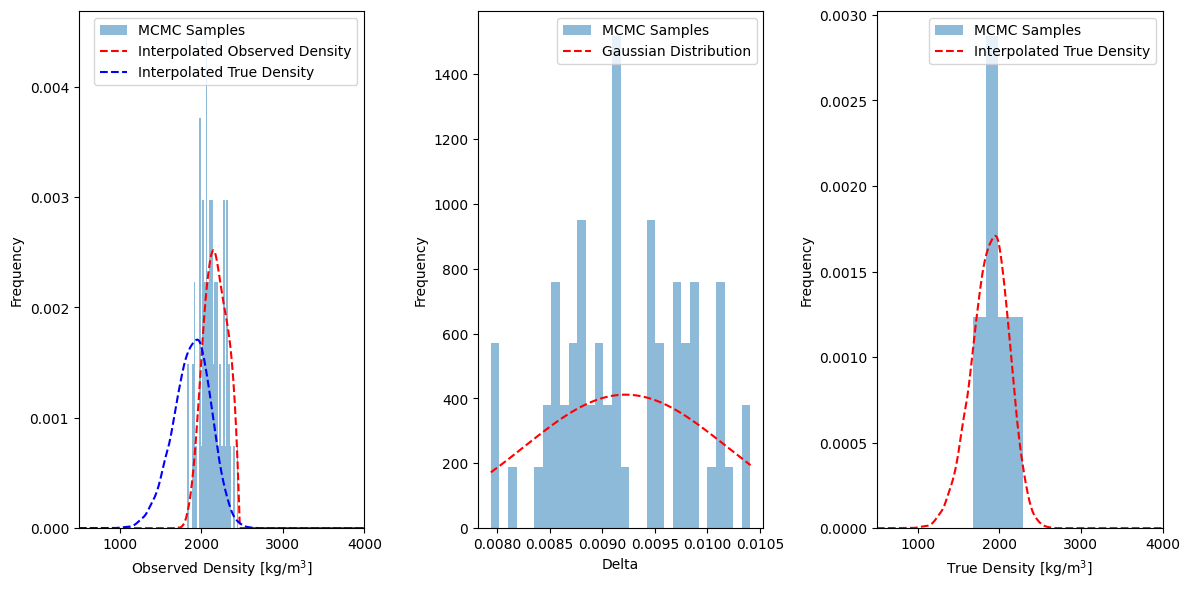

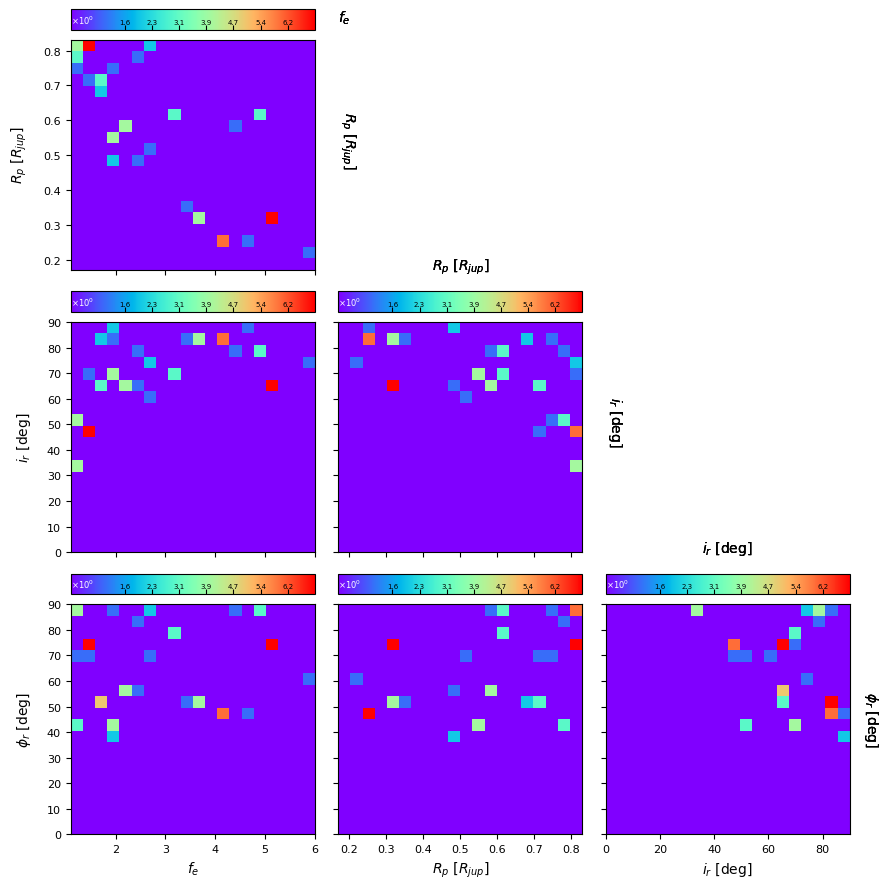

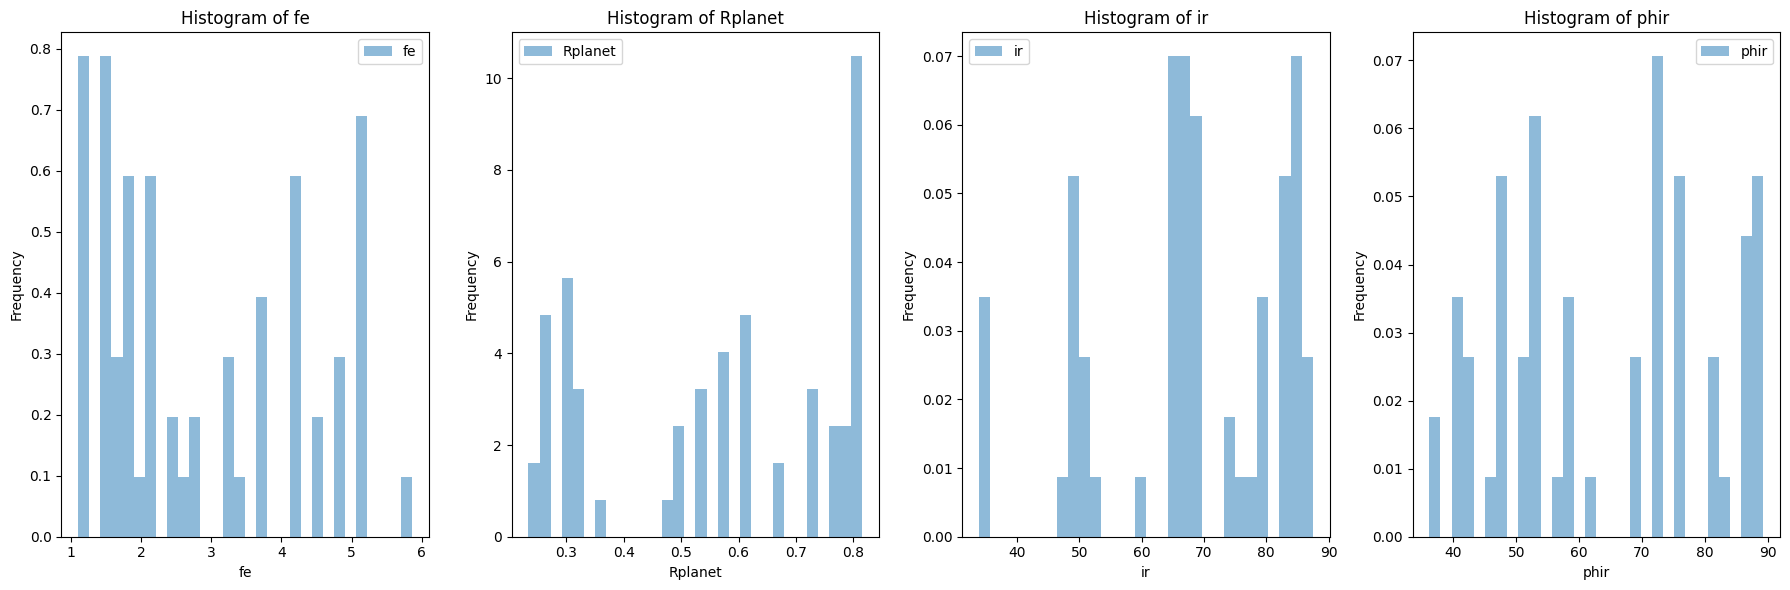

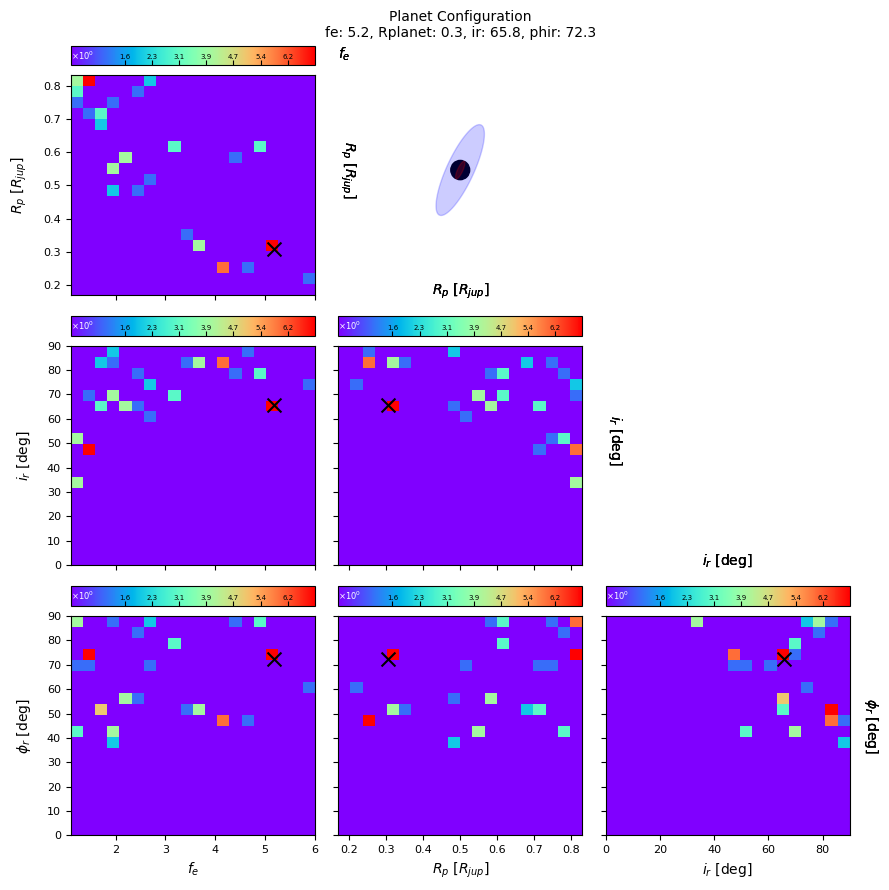

In [8]:
print(pr.BARL + "Plotting results\n" + pr.BARL)
plt.ioff();
pr.plotSample(Xs,S,props,prefix=f"{system_prefix}-{sample_suffix}",csargs=dict(alpha=0),chargs=dict(bins=20))
peak_point = pr.get_maximum_kde(Xs, props)
for prop, value in peak_point.items():
    setattr(S, prop, value * props[prop]['scale'])
pr.plotPlanet(Xs,S,props,prefix=f"{system_prefix}-{sample_suffix}")
plt.ion();

### Fixed radius

In [9]:
print(pr.BARL + "Monte Carlo fitting with fixed radius\n" + pr.BARL)

# Parameter space
System.Rplanet = Rp_min

props = dict(
    fe = dict(
        label=r"$f_e$",
        range=[1.1,10.0],
        scale=1,
    ),
    ir = dict(
        active=1,
        label=r"$i_r$ [deg]",
        range=[0.0, 90.0],
        scale=c.DEG,
    ),
    phir = dict(
        active=1,
        label=r"$\phi_r$ [deg]",
        range=[0.0, 90.0],
        scale=c.DEG,
    ),
)

# Parameters to store
store_params = dict(
    # Basic
    rho_true = dict(prop='rho_true',scale=1),
    rho_obs = dict(prop='rho_obs',scale=1),
    PR = dict(prop='PR',scale=1),
    ieff = dict(prop='ieff',scale=c.RAD),
    teff = dict(prop='teff',scale=c.RAD),
    delta = dict(prop='Ar',scale=1/np.pi),
    # Other
    Rplanet = dict(prop='Rplanet',scale=1/c.RJUP),
    Rstar = dict(prop='Rstar',scale=1/c.RSUN),
    Mstar = dict(prop='Mstar',scale=1/c.MSUN),
    ap = dict(prop='ap',scale=1/c.AU),
    ep = dict(prop='ep',scale=1),
    iorb = dict(prop='iorb',scale=c.RAD),
    Borb = dict(prop='Borb',scale=1),
    Porb = dict(prop='Porb',scale=1/c.DAY),
    tT = dict(prop='tT',scale=1),
    grazing = dict(prop='grazing',scale=1),
)

# Run
S = deepcopy(System)
S.tau = 1
S.fi = 1

# Name of the sample
sample_suffix = f"{sample_suffix}_NoRp-N{samples:.0e}"

print(f"Running {samples} samples with {num_procs} processors")
print(f"Sample suffix: {sample_suffix}")

# Prepare the data
Xs = pd.DataFrame([],columns=list(props.keys()) + ['rho_true', 'rho_obs', 'PR', 'ieff', 'teff', 'delta'])

# Loop over the grid
Nsamples = 0
n = 0 
glob_start_time = time.time()
for i in range(MS.shape[0]):
    for j in range(RS.shape[1]):
        n += 1 

        # Update stellar parameters
        S.Mstar = MS[i, j]*c.MSUN
        S.Rstar = RS[i, j]*c.RSUN
        S.updateSystem()
        
        # Calculate the number of samples required
        sub_samples = int(PS[i,j]*samples)
        
        print(f"Stellar parameters {n}: M_star = {S.Mstar/c.MSUN}, R_star = {S.Rstar/c.RSUN}, Number of samples: {sub_samples}")

        start_time = time.time()
        results = pr.parallel_mcra_grid(S, props, store_params, sub_samples, num_procs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"\tExecution time: {execution_time:.2f} seconds")

        Nsamples += len(results)

        # Accumulate
        if Nsamples > 0:
            Xs = pd.concat([Xs,results], ignore_index=True)
        
        # Save accumulated
        Xs.to_csv(f"{pr.PRDATA_DIR}/ringed_sample-{system_prefix}-{sample_suffix}.csv", index=False)
    
glob_end_time = time.time()
elapsed_time = glob_end_time - glob_start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed time: {int(hours):02}:{int(minutes):02}:{seconds:.2f} (hh:mm:ss)")
if alert:
    os.system('say "Tu programa ha terminado"')

**************************************************
Monte Carlo fitting with fixed radius
**************************************************

Running 100 samples with 4 processors
Sample suffix: MR_simple_variance-N1e+02_NoRp-N1e+02
Stellar parameters 1: M_star = 0.8150622084199416, R_star = 0.8110040099107445, Number of samples: 0
	Execution time: 0.05 seconds
Stellar parameters 2: M_star = 0.8648631458992002, R_star = 0.8110040099107445, Number of samples: 0
	Execution time: 0.03 seconds
Stellar parameters 3: M_star = 0.9146640833784587, R_star = 0.8110040099107445, Number of samples: 2
	Execution time: 0.04 seconds
Stellar parameters 4: M_star = 0.9644650208577173, R_star = 0.8110040099107445, Number of samples: 1
	Execution time: 0.03 seconds
Stellar parameters 5: M_star = 1.014265958336976, R_star = 0.8110040099107445, Number of samples: 0
	Execution time: 0.03 seconds
Stellar parameters 6: M_star = 0.8150622084199416, R_star = 0.8399178025856646, Number of samples: 0
	Execution ti

### Plotting

In [10]:
print(pr.BARL + "Plotting results\n" + pr.BARL)
plt.ioff();
pr.plotSample(Xs,S,props,prefix=f"{system_prefix}-{sample_suffix}",csargs=dict(alpha=0),chargs=dict(bins=20))
peak_point = pr.get_maximum_kde(Xs, props)
for prop, value in peak_point.items():
    setattr(S, prop, value * props[prop]['scale'])
pr.plotPlanet(Xs,S,props,prefix=f"{system_prefix}-{sample_suffix}")
plt.ion();

**************************************************
Plotting results
**************************************************

rho_obs: 2047.816233211343, p(rho_obs_fun): 0.0020205980947239884
delta: 0.009186982004995597, p(delta_fun): 411.53345957582457
Acceptance ratio: 0.8019115513330902
